## Python Environment Set Up for OpenSim

It will be easier to use conda for environment set up since OpenSim has created a package for conda.
### Create Conda Environment
```
conda create -n opensim_scripting python=3.11 numpy
conda activate opensim_scripting
```
### Install Opensim package
```
conda install -c opensim-org opensim opensim-moco
```
### Create Ipython Kernel using this environment
```
conda install -c anaconda ipykernel
python -m ipykernel install --user --name=opensim_scripting
```

And it's finished, open the jupyter notebook using the 'opensim_scripting' kernel and download other libraries such as matplotlib, c3d, and yaml.

## Dataset
Download C3D dataset from the link: 

https://figshare.com/articles/dataset/A_dataset_of_overground_walking_full-body_kinematics_and_kinetics_in_individuals_with_Parkinson_s_disease/14896881

Currently only need C3DFiles and PDFInfo for synthesizing IMU sensor data.

In [1]:
import c3d
import numpy as np
import yaml
import opensim
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def OpensimSetToList(OpensimSet):
    _list = []
    
    for i in range(OpensimSet.getSize()):
        _list.append(OpensimSet.get(i))
    
    return _list
    
def loadC3DToTRC(filepath, markerfilename,rename_config_path, model_type='gait_2392' ):
    '''Load C3D file to TRC Marker file'''
    if model_type not in ['gait2392','FullBodyModel']:
        raise Exception("Model Type Not Support.")

    reader = c3d.Reader(open(filepath,'rb'))
    table = opensim.TimeSeriesTableVec3()
    
    labels = list(map(lambda x: x.strip(), reader.point_labels))
    new_labels = []
    useful_label_index = []

    # Map the label to target opensim model marker set    
    with open(rename_config_path,'r') as file:
        rename_dict = yaml.safe_load(file)

    for i,orig_label in enumerate(labels):
        if orig_label[:2] == 'V_': continue # Remove un-used label 

        target_label = orig_label
        if orig_label in rename_dict[model_type]:
            target_label = rename_dict[model_type][orig_label]

        new_labels.append(target_label)
        useful_label_index.append(i)


    table.setColumnLabels(new_labels)

    num_frames = reader.header.last_frame - reader.header.first_frame+1
    datarate = reader.header.frame_rate
    table.addTableMetaDataString('DataRate', str(datarate))
    table.addTableMetaDataString('Units','mm')



    timestep = np.arange(0, num_frames * 1/datarate , 1/datarate)
    for i, points, analog in reader.read_frames():
        points_flatten = [opensim.Vec3(x) for x in points[useful_label_index,:3].tolist()] # only takes the x,y,z coordinates
        points_row = opensim.RowVectorVec3(points_flatten)
        table.appendRow(timestep[i-1],points_row)



    trcAdapter = opensim.TRCFileAdapter()
    trcAdapter.write(table,markerfilename)

In [3]:
def LoadAndScaleModel(modelPath, staticTRC, subject_info, outputScaleModel_path, outputMarkerModel_path ):
    '''Run OpenSim Scale Tool'''
    static_marker = opensim.MarkerData(staticTRC)
    initial_time = static_marker.getStartFrameTime()
    final_time = static_marker.getLastFrameTime()
    range_time = opensim.ArrayDouble()
    range_time.set(0,initial_time)
    range_time.set(1,final_time)


    static_marker_names = static_marker.getMarkerNames()
    static_marker_names_list = OpensimSetToList(static_marker_names)

    model = opensim.Model(modelPath)
    scale_tool = opensim.ScaleTool()
    scale_tool.getGenericModelMaker().setModelFileName(modelPath)

    '''Scale model to match patient info'''
    scale_tool.setSubjectMass(subject_info['mass'])
    scale_tool.setSubjectHeight(subject_info['height'])
    scale_tool.setSubjectAge(subject_info['age'])

    '''Remove unused Marker'''
    marker_set = model.getMarkerSet()
    new_marker_set = opensim.MarkerSet()

    for i in range(marker_set.getSize()):
        marker = marker_set.get(i)
        marker_name = marker.getName()

        if marker_name in static_marker_names_list:
            new_marker_set.cloneAndAppend(marker)

    model.updateMarkerSet(new_marker_set)


    '''Scale the Model According to subject Info'''
    model_scaler = scale_tool.getModelScaler()
    model_scaler.setApply(True)
    model_scaler.setTimeRange(range_time)
    model_scaler.setPreserveMassDist(True)
    # model_scaler.setOutputModelFileName(outputScaleModel_path)



    '''Place the marker on Model'''
    marker_placer = scale_tool.getMarkerPlacer()
    marker_placer.setApply(True)
    marker_placer.setTimeRange(range_time)
    marker_placer.setStaticPoseFileName(staticTRC)
    marker_placer.setOutputModelFileName(outputMarkerModel_path)
    # marker_placer.setMaxMarkerMovement(-1)
    scale_tool.run()




In [4]:
def ModelIK(modelPath, trialTRC, outputMot_path):
    '''Run OpenSim Inverse Kinematic Tool'''
    model_processor = opensim.ModelProcessor(modelPath)
    model_processor.append(opensim.ModOpRemoveMuscles()) # Remove Muscles
    model = model_processor.process()
    
    ik_tool = opensim.InverseKinematicsTool()
    ik_tool.setModel(model)
    ik_tool.setMarkerDataFileName(trialTRC)
    ik_tool.setOutputMotionFileName(outputMot_path)

    marker_data = opensim.MarkerData(trialTRC)
    start_time = marker_data.getStartFrameTime()
    end_time = marker_data.getLastFrameTime()

    ik_tool.setStartTime(start_time)
    ik_tool.setEndTime(end_time)

    ik_tool.run()

    del ik_tool
    del model

    return (start_time,end_time)

In [5]:
def visualize_model_motion(model_path, motion_path,geometry_path = './'):
    model_processor = opensim.ModelProcessor(model_path)
    model_processor.append(opensim.ModOpRemoveMuscles()) # Remove Muscles
    model = model_processor.process()
    motion = opensim.TimeSeriesTable(motion_path)
    viz = opensim.VisualizerUtilities()

    state = model.initSystem()


    viz.showMotion(model,motion)
    
def visualize_model(model_path):
    model = opensim.Model(model_path)
    model.setUseVisualizer(True)
    state = model.initSystem()
    viz = model.updVisualizer()
    viz.show(state)

In [6]:
def getTRCMOTfromC3D(subject, OnOff, trial, subject_info_path, model_type = 'gait2392', ModelOutput_dir = './ModelOutput/'):
    subject_static = C3D_dir + f'{subject}_{OnOff}/' + f'{subject}_{OnOff}_static_1.c3d'
    subject_walk_trial =  C3D_dir + f'{subject}_{OnOff}/' + f'{subject}_{OnOff}_walk_{trial}.c3d'
    
    targetTRCFile_walk = TRC_dir + f'{subject}_{OnOff}_walk_{trial}_markers_{model_type}.trc' 
    targetTRCFile_static = TRC_dir + f'{subject}_{OnOff}_static_markers_{model_type}.trc' 

    info_df = pd.read_excel(subject_info_path)
    subject_info = {}
    subject_info['age'] = int(info_df[info_df['ID']==subject]['Age'].item())
    subject_info['height'] = float(info_df[info_df['ID']==subject]['Height (cm)'].item() ) # cm -> mm
    subject_info['mass'] = float(info_df[info_df['ID']==subject]['Weight (kg)'].item())
    
    rename_config_path = "marker_rename_config.yml"
    if model_type == 'gait2392':
        model_path = './OpensimModel/gait2392_simbody_marker.osim'
    elif model_type == 'FullBodyModel':
        model_path = './OpensimModel/FullBodyModel.osim'
    
    outputScaleModel = ModelOutput_dir + f'{subject}_{model_type}_scale.osim'
    outputMarkerModel = ModelOutput_dir + f'{subject}_{model_type}_marker.osim'
    
    
    if not os.path.isfile(targetTRCFile_static):
        loadC3DToTRC(subject_static,targetTRCFile_static,rename_config_path,model_type)
    
    if not os.path.isfile(targetTRCFile_walk):
        loadC3DToTRC(subject_walk_trial,targetTRCFile_walk,rename_config_path,model_type)

    if not os.path.isfile(outputMarkerModel):
        LoadAndScaleModel(model_path, targetTRCFile_static,  subject_info, outputScaleModel_path = outputScaleModel, outputMarkerModel_path = outputMarkerModel)

    return outputMarkerModel, targetTRCFile_walk


In [7]:
def addIMUToBodySet(model, bodyName, translation, orientation):
    body = model.updBodySet().get(bodyName)
    name = str(body.getName()) + '_imu_offset'
    bodyOffset = opensim.PhysicalOffsetFrame(name, body, opensim.Transform())
    bodyOffset.set_translation(translation)
    bodyOffset.set_orientation(orientation)
    body.addComponent(bodyOffset)
    model.finalizeConnections()

    path = bodyOffset.getAbsolutePath().toString()
    bodyOffset.getParentFrame().upd_frame_geometry().set_display_radius(50)
    
    return path

In [8]:
def SolveIKGoal(model_file, motion_file , start_time, end_time , imuFramePaths, outputSolution_path, outputIMU_path):

    tableProcessor = opensim.TableProcessor(motion_file)
    
    model = opensim.Model(model_file)
    
    # Release Coordinates
    coordinates = OpensimSetToList(model.updCoordinateSet())
    for coor in coordinates:
        coor.setDefaultLocked(False)
        
    state = model.initSystem()

    model_processor = opensim.ModelProcessor(model)
    model_processor.append(opensim.ModOpRemoveMuscles()) # Remove Muscles

    # Moco Inverse Solver
    inverse = opensim.MocoInverse()
    inverse.setModel(model_processor)
    inverse.setKinematics(tableProcessor)
    
    inverse.set_initial_time(start_time)
    inverse.set_final_time(end_time)
    inverse.set_mesh_interval(0.01) # time interval for mesh interpolation
    inverse.set_convergence_tolerance(1e-4)
    inverse.set_constraint_tolerance(1e-4)
    
    inverse_study = inverse.initialize()
    inverse_solution = inverse.solve()
    inverse_solution.getMocoSolution().unseal().write(f'{outputSolution_path}_inverse_solution.sto')
    
    stateTable = inverse_solution.getMocoSolution().unseal().exportToStatesTable()
    controlTable = inverse_solution.getMocoSolution().unseal().exportToControlsTable()

    
    # Output Acclerometer Signal data
    outputaccelerometerPaths = opensim.StdVectorString()
    outputaccelerometerPaths.append('.*accelerometer_signal')
    
    accelerometerSignalTable = opensim.analyzeVec3(model_processor.process(),
        stateTable,
        controlTable,
        outputaccelerometerPaths)
    
    accelerometerSignalTable.setColumnLabels(imuFramePaths)

    #Output Gyroscope
    outputgyroscopePaths = opensim.StdVectorString()
    outputgyroscopePaths.append('.*gyroscope_signal')
    
    gyroscopeSignalTable = opensim.analyzeVec3(model_processor.process(),
        stateTable,
        controlTable,
        outputgyroscopePaths)
    
    gyroscopeSignalTable.setColumnLabels(imuFramePaths)

    # stoAdapter = opensim.STOFileAdapter()
    # stoAdapter.write(accelerometerSignalTable.flatten(),f'{outputIMU_path}_accelerometer_signal.sto')
    # stoAdapter.write(gyroscopeSignalTable.flatten(), f'{outputIMU_path}_gyroscope_signal.sto')

    return accelerometerSignalTable, gyroscopeSignalTable

def visualizeSolution(model_file,solution_file):
    model_processor = opensim.ModelProcessor(model_file)
    model_processor.append(opensim.ModOpRemoveMuscles()) # Remove Muscles
    model = model_processor.process()
    study = opensim.MocoStudy()
    solution = opensim.MocoTrajectory(solution_file)
    problem = study.updProblem()
    
    problem.setModel(model)
    study.visualize(solution)

In [9]:
from typing import NamedTuple

class IMUData(NamedTuple):
    body: str
    translation: opensim.Vec3
    rotation: opensim.Vec3   

def AddImu2Model(model_path, imu_list):
    model = opensim.Model(model_path)
    
     # Add IMU to model    
    imuFramePaths = opensim.StdVectorString()
    for imu_data in imu_list:
        imu = addIMUToBodySet(model, imu_data.body , imu_data.translation, imu_data.rotation)
        imuFramePaths.append(imu)

    imus = opensim.OpenSenseUtilities().addModelIMUs(model, imuFramePaths)

    output_model_name = model_path.split('.osim')[0] + '_imu.osim'
    model.printToXML(output_model_name)
    
    return imuFramePaths , output_model_name

In [10]:
def get_time(table):
    timeVec = table.getIndependentColumn()
    time = np.zeros(len(timeVec))
    for i in np.arange(len(timeVec)):
       time[i] = timeVec[i]
        
    return time

def to_mat(vectorVec3):
        mat = np.zeros((vectorVec3.size(), 3))
        for i in np.arange(vectorVec3.size()):
            for j in np.arange(3):
                mat[i,j] = vectorVec3[int(i)][int(j)]
        return mat

def plot_imu_signal(table,title):
    time = get_time(table)
    
    columns = table.getColumnLabels()

    fig ,axs = plt.subplots(len(columns),1,figsize=(10,3*len(columns)))

    for i, col in enumerate(columns):
        mat = to_mat(table.getDependentColumn(col))
        for j , axis in enumerate(['x','y','z']):
            axs[i].plot(time,mat[:,j],label=axis)
        axs[i].set_title(col.split('/')[-1])
        axs[i].legend()

    fig.suptitle(title)
    plt.show()

    return fig

def plot_imu_signal_on_same_plot(table,title,ylim=None):
    time = get_time(table)
    
    columns = table.getColumnLabels()

    fig = plt.figure(figsize=(12,3))
    for i, col in enumerate(columns):
        mat = to_mat(table.getDependentColumn(col))
        for j , axis in enumerate(['x','y','z']):
            plt.plot(time,mat[:,j],label=f"{col.split('/')[-1]}-{axis}-axis")

        fig.legend()

    if ylim is not None:
        plt.ylim(ylim)
    plt.title(title)
    plt.show()
    return fig

def plot_imu_signal_distribution(table,bins=30,title="default"):
    columns = table.getColumnLabels()

    fig ,axs = plt.subplots(len(columns),1,figsize=(10,3*len(columns)))

    for i, col in enumerate(columns):
        mat = to_mat(table.getDependentColumn(col))
        for j , axis in enumerate(['x','y','z']):
            axs[i].hist(mat[:,j],bins=bins,label=axis)
        axs[i].set_title(col.split('/')[-1])
        axs[i].legend()

    fig.suptitle(title)
    plt.show()

    return fig
    
def plot_imu_signal_distribution_on_same_plot(table,bins=30,title="default"):
    columns = table.getColumnLabels()
    fig = plt.figure(figsize=(12,3))
    for i, col in enumerate(columns):
        mat = to_mat(table.getDependentColumn(col))
        for j , axis in enumerate(['x','y','z']):
            plt.hist(mat[:,j],bins=bins,label=f"{col.split('/')[-1]}-{axis}-axis")

        fig.legend()

    plt.title(title)
    plt.show()
    return fig

def calculate_distribution_statistic(table,bins=30):
    columns = table.getColumnLabels()

    mean = {}
    std = {}
    
    for i, col in enumerate(columns):
        mat = to_mat(table.getDependentColumn(col))
        mean[col.split('/')[-1]] = np.mean(mat)
        std[col.split('/')[-1]] = np.std(mat)

    return mean,std

def calculate_axis_distribution_statistic(table,bins=30):
    columns = table.getColumnLabels()

    mean = {}
    std = {}
    
    for i, col in enumerate(columns):
        mat = to_mat(table.getDependentColumn(col))
        mean[col.split('/')[-1]]  = {}
        std[col.split('/')[-1]] = {}
        for j , axis in enumerate(['x','y','z']):
            data = mat[:,j]
            mean[col.split('/')[-1]][axis] = np.mean(data)
            std[col.split('/')[-1]][axis] = np.std(data)

    return mean,std


In [11]:
C3D_dir = './C3Dfiles/' # The C3D data from the dataset
TRC_dir = './TRCFolder/'
MOT_dir = './MOTFolder/'
ModelOutput_dir = './ModelOutput/'
solution_dir = './IKSolution/'
imu_dir = './IMU/'


os.makedirs(TRC_dir,exist_ok=True)
os.makedirs(MOT_dir,exist_ok=True)
os.makedirs(ModelOutput_dir,exist_ok=True)
os.makedirs(solution_dir,exist_ok=True)
os.makedirs(imu_dir,exist_ok=True)

subject_info_path = './PDGinfo.xlsx' # Subject Information from the dataset

In [42]:
def pipeline(subject,OnOff,trial,model_type='FullBodyModel', return_viz_file = False):
    # load and scale model with marker and walk trc file
    outputMarkerModel, targetTRCFile_walk = getTRCMOTfromC3D(subject ,
                                                             OnOff,
                                                             trial,
                                                             subject_info_path,
                                                             model_type,
                                                             ModelOutput_dir)
    
    
    # Add IMU to Model ( x,y,z ) => (front, up, right)
    imu1 = IMUData('hand_r', opensim.Vec3(0, -0.0, 0.05), opensim.Vec3(0, 0 , 0.5*np.pi))
    imu2 = IMUData('femur_r',  opensim.Vec3(0, -0.2, 0.05), opensim.Vec3(0, 0, 0.5*np.pi))
    imu3 = IMUData('tibia_r',  opensim.Vec3(0, -0.2, 0.05), opensim.Vec3(0, 0, 0.5*np.pi))
    
    imu4 = IMUData('hand_l', opensim.Vec3(0,-0.0, -0.05), opensim.Vec3(0, 0 , -0.5*np.pi))
    imu5 = IMUData('femur_l', opensim.Vec3(0, -0.2, -0.05), opensim.Vec3(0, 0, -0.5*np.pi))
    imu6 = IMUData('tibia_l', opensim.Vec3(0, -0.2, -0.05), opensim.Vec3(0, 0, -0.5*np.pi))
    
    imu_list = [imu1,imu2,imu3,imu4,imu5,imu6]
    
    imuFramePaths , outputIMUModel = AddImu2Model(outputMarkerModel,imu_list)
    
    # Calculate Inverse Kinematic using model
    outputMot = MOT_dir + f'{subject}_{OnOff}_walk_{trial}_{model_type}.mot'
    start_time,end_time = ModelIK(outputIMUModel, targetTRCFile_walk, outputMot)
    
    # Calculate IMU and joint angle using Inverse Kinematic Result
    solution_path = solution_dir + f'{subject}_{OnOff}_walk_{trial}_{model_type}'
    imu_path = imu_dir + f'{subject}_{OnOff}_walk_{trial}_{model_type}'
    
    
    acc_signal_table,gyro_signal_table = SolveIKGoal(outputIMUModel, 
                                                     outputMot , 
                                                     start_time , 
                                                     end_time - 0.001 , 
                                                     imuFramePaths,
                                                     solution_path, 
                                                     imu_path)
    
    if return_viz_file:
        return acc_signal_table, gyro_signal_table , outputIMUModel, f'{solution_path}_inverse_solution.sto'
    
    return acc_signal_table, gyro_signal_table

In [39]:
acc , gyro , model , solution = pipeline('SUB01','off', 1 , return_viz_file=True)

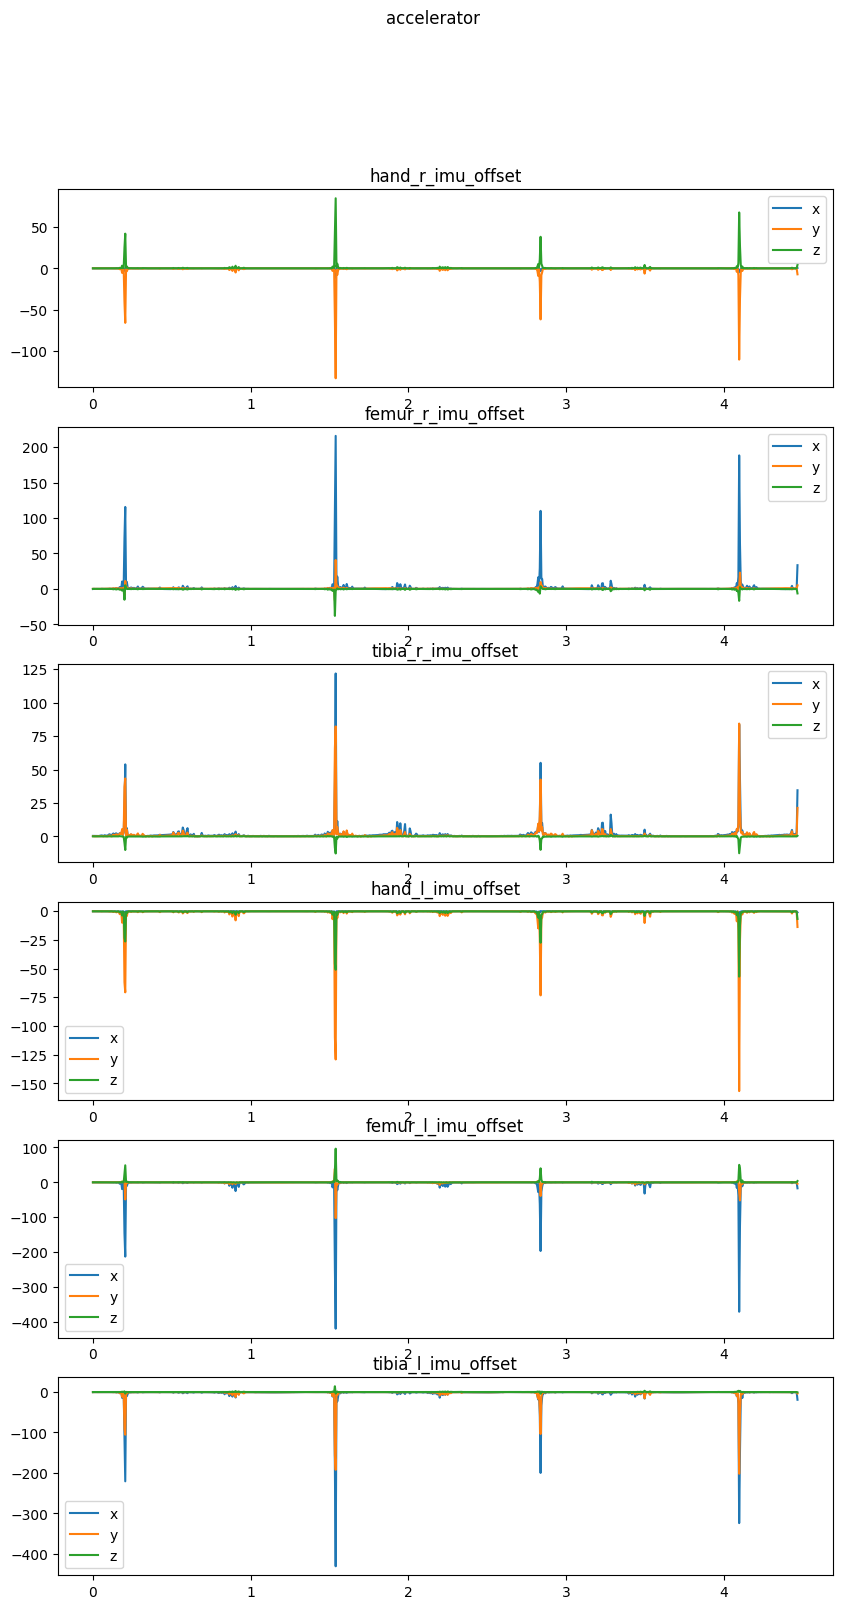

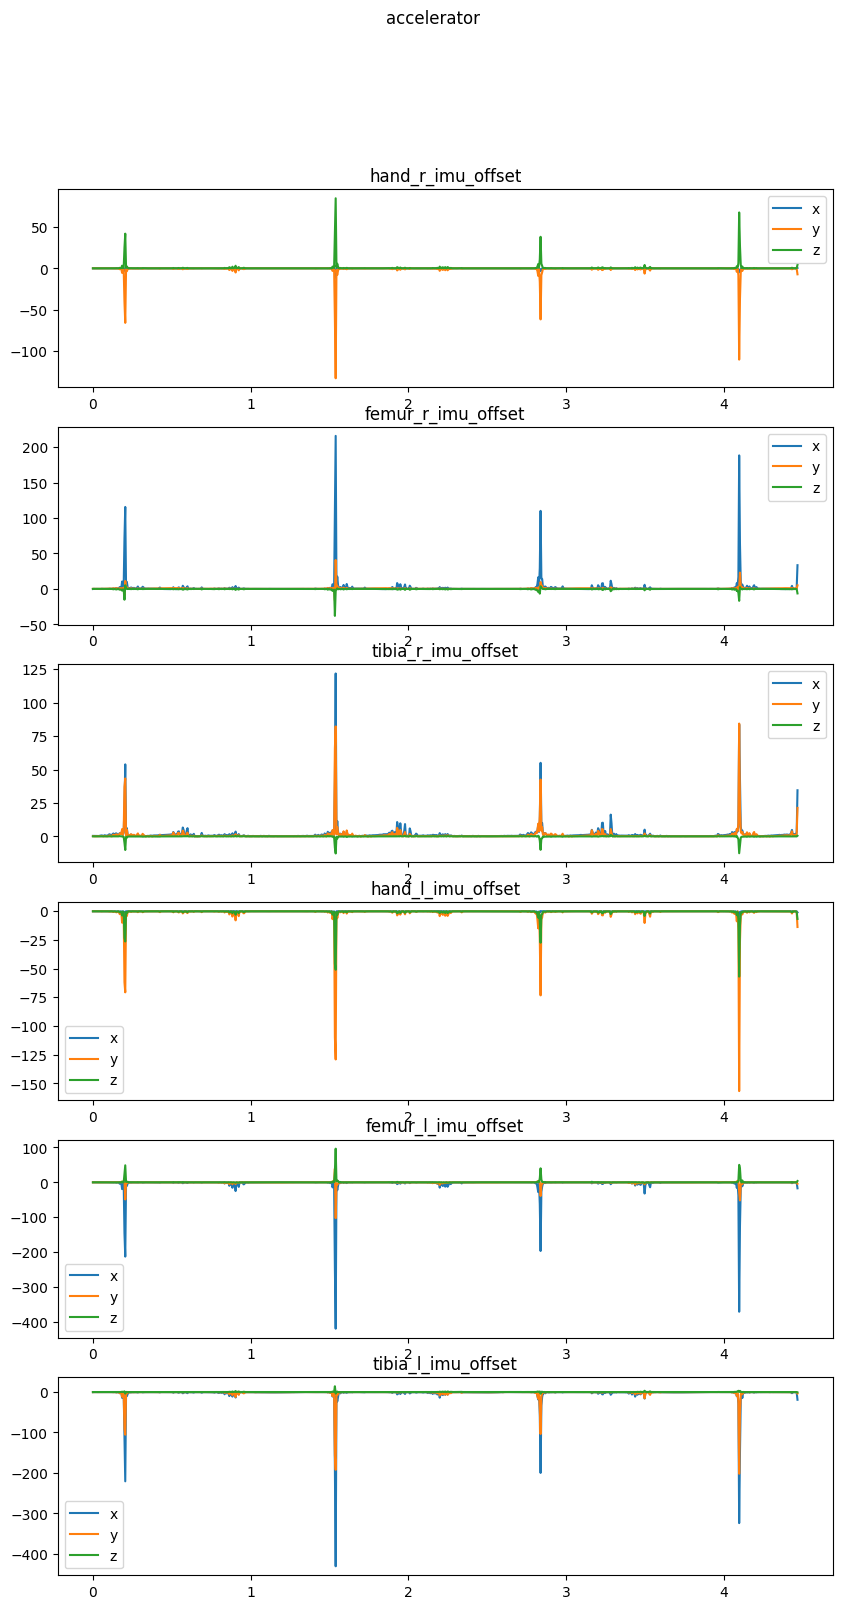

In [40]:
plot_imu_signal(acc,title="accelerator")

In [41]:
try:
    # visualizeSolution(outputIMUModel,f'{solution_path}_inverse_solution.sto')
    # visualize_model_motion(outputIMUModel,outputMot)
    visualize_model(model)
except:
    print('Close Visualization Window.')

In [33]:
_model = opensim.Model(model)
bodyset = OpensimSetToList(_model.getBodySet())
jointset = OpensimSetToList(_model.getJointSet())
print([body.getName() for body in bodyset])
print([joint.getName() for joint in jointset])

['pelvis', 'femur_r', 'tibia_r', 'patella_r', 'talus_r', 'calcn_r', 'toes_r', 'femur_l', 'tibia_l', 'patella_l', 'talus_l', 'calcn_l', 'toes_l', 'torso', 'humerus_r', 'ulna_r', 'radius_r', 'hand_r', 'humerus_l', 'ulna_l', 'radius_l', 'hand_l']
['ground_pelvis', 'hip_r', 'walker_knee_r', 'patellofemoral_r', 'ankle_r', 'subtalar_r', 'mtp_r', 'hip_l', 'walker_knee_l', 'patellofemoral_l', 'ankle_l', 'subtalar_l', 'mtp_l', 'back', 'acromial_r', 'elbow_r', 'radioulnar_r', 'radius_hand_r', 'acromial_l', 'elbow_l', 'radioulnar_l', 'radius_hand_l']


In [15]:
import cv2
def frames2video(frame_path,fps=24,second=3,save_name=None):
    image_folder = frame_path
    video_name = save_name + '.avi'
    
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")][:fps*second]
    
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    
    height, width, layers = frame.shape
    
    video = cv2.VideoWriter(video_name, 0, fps, (width,height))
    
    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))
    
    cv2.destroyAllWindows()
    video.release()

In [16]:
# frames2video('python_4',fps=24,second=4,save_name=f'{subject}_{OnOff}_walk_{trial}')

### Generate IMU for all patient and trial

In [17]:
import glob

subject_off = glob.glob('C3Dfiles/*_off')
subject_on = glob.glob('C3Dfiles/*_on')

In [18]:
print(subject_off,subject_on)

['C3Dfiles\\SUB01_off', 'C3Dfiles\\SUB02_off', 'C3Dfiles\\SUB03_off', 'C3Dfiles\\SUB05_off', 'C3Dfiles\\SUB06_off', 'C3Dfiles\\SUB07_off', 'C3Dfiles\\SUB08_off', 'C3Dfiles\\SUB09_off', 'C3Dfiles\\SUB10_off', 'C3Dfiles\\SUB11_off', 'C3Dfiles\\SUB12_off', 'C3Dfiles\\SUB13_off', 'C3Dfiles\\SUB14_off', 'C3Dfiles\\SUB15_off', 'C3Dfiles\\SUB16_off', 'C3Dfiles\\SUB17_off', 'C3Dfiles\\SUB18_off', 'C3Dfiles\\SUB19_off', 'C3Dfiles\\SUB20_off', 'C3Dfiles\\SUB21_off', 'C3Dfiles\\SUB22_off', 'C3Dfiles\\SUB24_off', 'C3Dfiles\\SUB26_off'] ['C3Dfiles\\SUB01_on', 'C3Dfiles\\SUB02_on', 'C3Dfiles\\SUB03_on', 'C3Dfiles\\SUB04_on', 'C3Dfiles\\SUB05_on', 'C3Dfiles\\SUB06_on', 'C3Dfiles\\SUB07_on', 'C3Dfiles\\SUB08_on', 'C3Dfiles\\SUB09_on', 'C3Dfiles\\SUB10_on', 'C3Dfiles\\SUB11_on', 'C3Dfiles\\SUB12_on', 'C3Dfiles\\SUB13_on', 'C3Dfiles\\SUB14_on', 'C3Dfiles\\SUB15_on', 'C3Dfiles\\SUB16_on', 'C3Dfiles\\SUB17_on', 'C3Dfiles\\SUB18_on', 'C3Dfiles\\SUB19_on', 'C3Dfiles\\SUB20_on', 'C3Dfiles\\SUB21_on', 'C3Dfil

In [19]:
subject_with_off = [os.path.basename(x).split('_')[0] for x in subject_off]
subject_with_on = [os.path.basename(x).split('_')[0] for x in subject_on]

In [20]:
SyntheticIMUDir = './SyntheticIMU/'
os.makedirs(SyntheticIMUDir,exist_ok=True)

In [21]:
# model_type = 'FullBodyModel'


# for subject_dir in subject_off + subject_on:
#     subject_dir_base = os.path.basename(subject_dir)
#     subject_off_trial = glob.glob(f'{subject_dir}/*_walk_*.c3d')
#     for file in subject_off_trial:
#         print(f"Processing file:{file}")
#         base = os.path.basename(file)
#         _split = base.split('_')
#         if len(_split) > 4: continue
#         subject , OnOff, trial = _split[0], _split[1], _split[3]
#         trial = trial.split('.')[0]

#         os.makedirs(os.path.join(SyntheticIMUDir,subject),exist_ok=True)
#         os.makedirs(os.path.join(SyntheticIMUDir,subject,OnOff),exist_ok=True)

#         if os.path.isfile(os.path.join(SyntheticIMUDir,subject,OnOff,f"{subject}_{OnOff}_{trial}_acc.sto")) and os.path.isfile(os.path.join(SyntheticIMUDir,subject,OnOff,f"{subject}_{OnOff}_{trial}_gyro.sto")):
#             continue
            
#         else:
#             acc, gyro = pipeline(subject,OnOff,trial,model_type='FullBodyModel')
#             sto = opensim.STOFileAdapter()
#             sto.write(acc.flatten(),os.path.join(os.path.join(SyntheticIMUDir,subject,OnOff,f"{subject}_{OnOff}_{trial}_acc.sto")))
#             sto.write(gyro.flatten(),os.path.join(os.path.join(SyntheticIMUDir,subject,OnOff,f"{subject}_{OnOff}_{trial}_gyro.sto")))

        